In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00484_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00541_4.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00305_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00052_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00218_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00353_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00013_3.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00093_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00559_4.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00518_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00554_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data

In [2]:
pip install -U git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-rdw23xfd
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-rdw23xfd
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=df87c2fafaef33349f0313444c3344cdd14513277b4077a6fadd625aff54ac48
  Stored in directory: /tmp/pip-ephem-wheel-cache-4sny4cyu/wheels/16/9b/76/6e33fba6f1888d8c6e0faf79bb28198229cb8dfab1a502558d
Successfully built segmentation_models
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage.transform import resize

2025-07-27 16:15:03.004536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753632903.182131      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753632903.233934      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


100%|██████████| 2940/2940 [01:01<00:00, 47.77it/s]


✅ Data loaded:
X_train shape: (2940, 128, 128, 3)
Y_train shape: (2940, 128, 128, 1)
Max value in X_train: 255
Unique values in Y_train: [False  True]


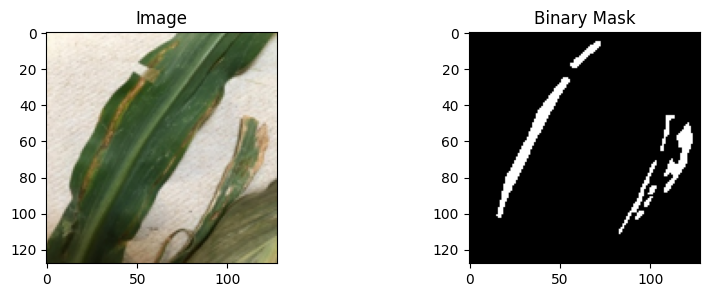

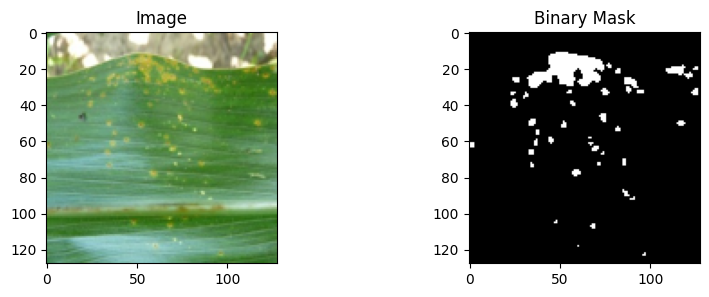

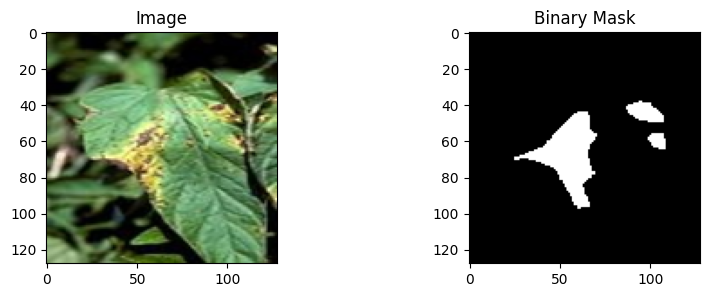

In [4]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Directories of the augmented dataset
train_image_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images"
train_mask_dir  = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"

image_files = [f for f in os.listdir(train_image_dir) if f.endswith(".jpg")]

X_train = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i, file_name in enumerate(tqdm(image_files)):
    img_path = os.path.join(train_image_dir, file_name)
    mask_name = os.path.splitext(file_name)[0] + ".png"  # replace .jpg with .png
    mask_path = os.path.join(train_mask_dir, mask_name)

    if not os.path.exists(mask_path):
        print(f"⚠️ No mask exists for: {mask_name}")
        continue

    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
    mask = Image.open(mask_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))

    mask_array = np.array(mask)

    if np.max(mask_array) == 0:
        print(f"⚠️ Empty mask for: {mask_name}")

    X_train[i] = np.array(img)
    Y_train[i] = np.expand_dims(mask_array > 10, axis=-1)  # binarization

print("✅ Data loaded:")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("Max value in X_train:", np.max(X_train))
print("Unique values in Y_train:", np.unique(Y_train))

# Display a few images and masks
for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[i].squeeze(), cmap="gray")
    plt.title("Binary Mask")
    plt.show()


In [5]:
def build_backbone(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )

    layer_names = [
        "conv2_block3_out",  # 1/4 resolution
        "conv3_block4_out",  # 1/8
        "conv4_block6_out",  # 1/16
    ]
    layers_output = [base_model.get_layer(name).output for name in layer_names]
    backbone = tf.keras.Model(inputs=base_model.input, outputs=layers_output)
    backbone.trainable = False  # puedes cambiarlo si deseas fine-tuning
    return backbone

In [6]:
def ASPP(x):
    dims = x.shape
    y1 = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
    y2 = layers.Conv2D(256, 3, dilation_rate=6, padding="same", activation="relu")(x)
    y3 = layers.Conv2D(256, 3, dilation_rate=12, padding="same", activation="relu")(x)
    y4 = layers.Conv2D(256, 3, dilation_rate=18, padding="same", activation="relu")(x)
    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1, 1, y5.shape[1]))(y5)
    y5 = layers.Conv2D(256, 1, padding="same", activation="relu")(y5)
    y5 = layers.UpSampling2D(size=(dims[1], dims[2]), interpolation="bilinear")(y5)
    
    y = layers.Concatenate()([y1, y2, y3, y4, y5])
    return layers.Conv2D(256, 1, padding="same", activation="relu")(y)

def DeepLabV3Plus(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    backbone = build_backbone(input_shape)
    low_level_feat, mid_feat, high_feat = backbone(inputs)

    x = ASPP(high_feat)
    x = layers.Dropout(0.3)(x)  # added dropout
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low = layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low = layers.BatchNormalization()(low)
    low = layers.Activation("swish")(low)

    x = layers.Concatenate()([x, low])

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.Dropout(0.3)(x)  # added dropout
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [7]:
model = DeepLabV3Plus()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=8
)

I0000 00:00:1753632992.606243      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 32, 32, 256),  │      8,589,184 │ input_layer[0][0]      │
│                           │ (None, 16, 16, 512),   │                │                        │
│                           │ (None, 8, 8, 1024)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1024)           │              0 │ functional[0][2]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1024)     │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 1, 1, 256)      │        262,400 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 256)      │        262,400 │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 256)      │      2,359,552 │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 256)      │      2,359,552 │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 256)      │      2,359,552 │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 8, 8, 256)      │              0 │ conv2d_4[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 1280)     │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0],        │
│                           │                        │                │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 256)      │        327,936 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 48)     │         12,288 │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8, 8, 256)      │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 48)     │            192 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 17,825,601 (68.00 MB)

 Trainable params: 9,235,297 (35.23 MB)

 Non-trainable params: 8,590,304 (32.77 MB)

Epoch 1/20


I0000 00:00:1753633007.956437     165 service.cc:148] XLA service 0x7b3aa0004160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753633007.957090     165 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753633009.537836     165 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/294 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.6206 - loss: 0.7345   

I0000 00:00:1753633018.797986     165 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


294/294 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.8450 - loss: 0.3669 - val_accuracy: 0.9073 - val_loss: 0.2238
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9085 - loss: 0.2166 - val_accuracy: 0.9235 - val_loss: 0.1811
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9210 - loss: 0.1869 - val_accuracy: 0.9187 - val_loss: 0.2029
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9341 - loss: 0.1602 - val_accuracy: 0.9317 - val_loss: 0.1643
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9403 - loss: 0.1449 - val_accuracy: 0.9413 - val_loss: 0.1425
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9452 - loss: 0.1326 - val_accuracy: 0.9472 - val_loss: 0.1329
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9525 - loss: 0.1161 - val_accuracy: 0.9481 - val_loss: 0.1367
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9507 - loss: 0.1196 - val_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


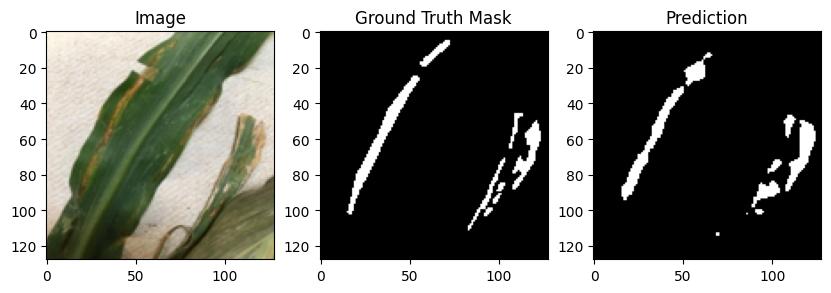

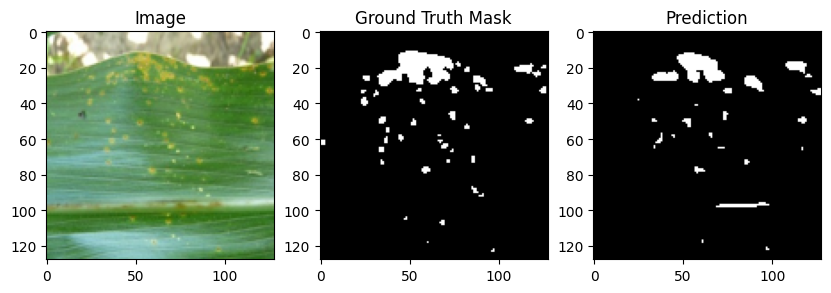

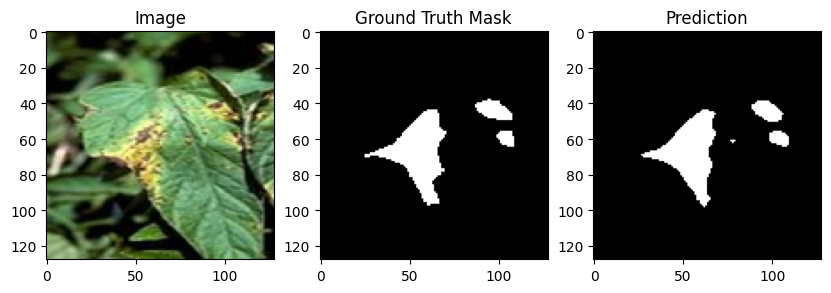

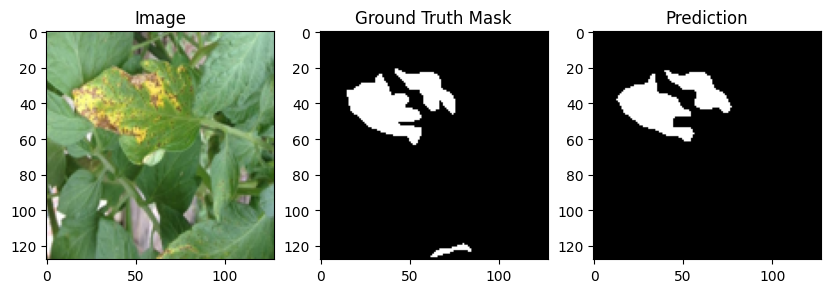

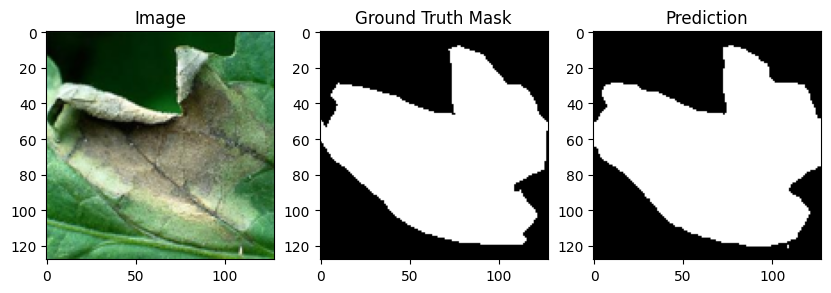

In [8]:
preds = model.predict(X_train[:5])
for i in range(5):
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i])
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(Y_train[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze() > 0.5, cmap="gray")
    plt.title("Prediction")
    
    plt.show()


In [9]:
# The 'history' object already contains the training history
train_acc = history.history['accuracy'][-1]        # Final training accuracy
val_acc = history.history['val_accuracy'][-1]      # Final validation accuracy

# A value you stored for final accuracy in your block 9
unetacc = train_acc  

print(f"Final training accuracy: {train_acc:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")


Final training accuracy: 0.9689
Final validation accuracy: 0.9558
